In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm

In [30]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = False
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

In [4]:
generate_data = True
directory = "/hpcwork/zu992399/look_elsewhere/binned_test/"


# Generate Data

In [104]:
bins = 5
bins_edge = 2
N = 10000
N_tests = 100000

In [105]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(sig))

def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_value_binomial(N_data, N_BT, N_total):
    p_value = 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)
    p_left = stats.binom.cdf(N_data, N_total, N_BT/N_total) 
    return np.min(np.array([p_value, p_left]), axis=0)*2
    #return p_value

In [82]:
if generate_data:
    def do_test_val(N_tests, bins, N, bins_edge = None, independent_test=True):
        rv = multivariate_normal([0,0], [[1,0],[0,1]])
        if bins_edge is None:
            edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
        else:
            edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

        exp = np.zeros((bins,bins))
        for i in range(bins):
            for j in range(bins):
                exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

        p_train = np.zeros((bins,bins, N_tests))
        p_val = np.zeros((bins,bins, N_tests))
        p_train_val = np.zeros((bins,bins, N_tests))
        p_test = np.zeros((bins,bins, N_tests))
        for k in tqdm.tqdm(range(N_tests)):
            data = rv.rvs(size=N, random_state=k)
            hist_train = np.histogramdd(data, bins=edges)[0]
            p_train[:,:,k] = p_value_binomial(hist_train, exp, N)

            data = rv.rvs(size=N, random_state=k+2*N_tests)
            hist_val = np.histogramdd(data, bins=edges)[0]
            p_val[:,:,k] = p_value_binomial(hist_val, exp, N)

            p_train_val[:,:,k] = p_value_binomial(hist_train+hist_val, exp*2, 2*N)

            data = rv.rvs(size=N, random_state=N_tests+k)
            hist = np.histogramdd(data, bins=edges)[0]
            p_test[:,:,k] = p_value_binomial(hist, exp, N)

        return p_train, p_val, p_train_val, p_test 

    p_train, p_val, p_train_val, p_test = do_test_val(N_tests, bins, N, bins_edge=bins_edge)

    min_ind_on_train = np.argmin(p_train.reshape((bins*bins, N_tests)), axis=0)
    p_train_pick_on_train = [p_train.reshape((bins*bins,N_tests))[min_ind_on_train[i],i] for i in range(N_tests)]
    p_test_pick_on_train = [p_test.reshape((bins*bins,N_tests))[min_ind_on_train[i],i] for i in range(N_tests)]

    min_ind_on_train_val = np.argmin(np.argsort(np.argsort(p_train.reshape((bins*bins, N_tests)), axis=0), axis=0)+np.argsort(np.argsort(p_val.reshape((bins*bins,N_tests)), axis=0), axis=0), axis=0)
    p_train_pick_on_train_val = [p_train.reshape((bins*bins,N_tests))[min_ind_on_train_val[i],i] for i in range(N_tests)]
    p_val_pick_on_train_val = [p_val.reshape((bins*bins,N_tests))[min_ind_on_train_val[i],i] for i in range(N_tests)]
    p_train_val_pick_on_train_val = [p_train_val.reshape((bins*bins,N_tests))[min_ind_on_train_val[i],i] for i in range(N_tests)]
    p_test_pick_on_train_val = [p_test.reshape((bins*bins,N_tests))[min_ind_on_train_val[i],i] for i in range(N_tests)]

    np.save(directory+"validation/p_train_pick_on_train.npy", p_train_pick_on_train)
    np.save(directory+"validation/p_train_pick_on_train_val.npy", p_train_pick_on_train_val)
    np.save(directory+"validation/p_test_pick_on_train.npy", p_test_pick_on_train)
    np.save(directory+"validation/p_test_pick_on_train_val.npy", p_test_pick_on_train_val)
    np.save(directory+"validation/p_val_pick_on_train_val.npy", p_val_pick_on_train_val)
    np.save(directory+"validation/p_train_val_pick_on_train_val.npy", p_train_val_pick_on_train_val)

100%|██████████| 100000/100000 [05:52<00:00, 283.81it/s]


In [106]:
def do_test_kfold_valset(N_tests, bins, N, bins_edge = None, folds=5):
    rv = multivariate_normal([0,0], [[1,0],[0,1]])
    if bins_edge is None:
        edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
    else:
        edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

    exp = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

    #p_poisson = np.zeros((bins,bins, N_tests))
    p_test = np.zeros((N_tests, folds))
    p_test_with_val = np.zeros((N_tests, folds))
    p_global = np.zeros((N_tests))
    p_add = np.zeros((N_tests))
    p_global_with_val = np.zeros((N_tests))
    p_add_with_val = np.zeros((N_tests))
    p_only_train = np.zeros((N_tests, bins*bins, folds))
    p_train = np.zeros((N_tests, bins*bins, folds))
    p_val = np.zeros((N_tests, bins*bins, folds))
    train_val_split = int((folds-1)/2)
    for k in tqdm.tqdm(range(N_tests)):
        hist = np.zeros((bins,bins, folds))
        N_test = np.zeros((folds))
        exp_test = np.zeros((folds))
        best_bin = np.zeros((folds), dtype=int)

        N_test_with_val = np.zeros((folds))
        exp_test_with_val = np.zeros((folds))
        best_bin_with_val = np.zeros((folds), dtype=int)

        data = np.array_split(rv.rvs(size=N, random_state=k), folds)
        for m in range(folds):
            hist[:,:,m] = np.histogramdd(data[m], bins=edges)[0]

        for m in range(folds):
            inds = np.roll(np.array(range(folds)), m)

            p_train[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[:train_val_split]],axis=-1), exp*(train_val_split)/folds, N*(train_val_split)/folds).flatten()
            p_val[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[train_val_split:-1]],axis=-1), exp*((folds-train_val_split-1))/folds, N*(folds-train_val_split-1)/folds).flatten()
            p_only_train[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[:-1]],axis=-1), exp*(folds-1)/folds, N*(folds-1)/folds).flatten()

            best_bin[m] = np.argmin(p_only_train[k, :,m])
            N_test[m] = hist[:,:,inds[-1]].flatten()[best_bin[m]]
            exp_test[m] = exp.flatten()[best_bin[m]]/5
            p_test[k,m] = p_value_binomial(hist.reshape((bins*bins,folds))[best_bin[m],inds[-1]], exp.flatten()[best_bin[m]]/folds, N/folds)

            best_bin_with_val[m] = np.argmin(np.argsort(np.argsort(p_train[k, :,m]))+np.argsort(np.argsort(p_val[k,:, m])))
            N_test_with_val[m] = hist[:,:,inds[-1]].flatten()[best_bin_with_val[m]]
            exp_test_with_val[m] = exp.flatten()[best_bin_with_val[m]]/5
            p_test_with_val[k,m] = p_value_binomial(hist.reshape((bins*bins,folds))[best_bin_with_val[m],inds[-1]], exp.flatten()[best_bin_with_val[m]]/folds, N/folds)
            
        #print(np.sum(N_test), np.sum(exp_test))
        p_add[k] = p_value_binomial(np.sum(N_test), np.sum(exp_test), N)
        p_global[k] = 1-stats.chi2.cdf(-2*np.sum(np.log(p_test[k])), 2*folds)

        p_add_with_val[k] = p_value_binomial(np.sum(N_test_with_val), np.sum(exp_test_with_val), N)
        p_global_with_val[k] = 1-stats.chi2.cdf(-2*np.sum(np.log(p_test_with_val[k])), 2*folds)

    return p_add, p_global, p_add_with_val, p_global_with_val

if generate_data: 
    p_add, p_global, p_add_with_val, p_global_with_val = do_test_kfold_valset(N_tests, bins, N, bins_edge=bins_edge)
    np.save(directory+"k_fold/fishers_method.npy", p_global)
    np.save(directory+"k_fold/addition.npy", p_add)
    np.save(directory+"k_fold/fishers_method_with_validation.npy", p_global_with_val)
    np.save(directory+"k_fold/addition_with_validation.npy", p_add_with_val)


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [09:03<00:00, 183.87it/s]


# Plot results

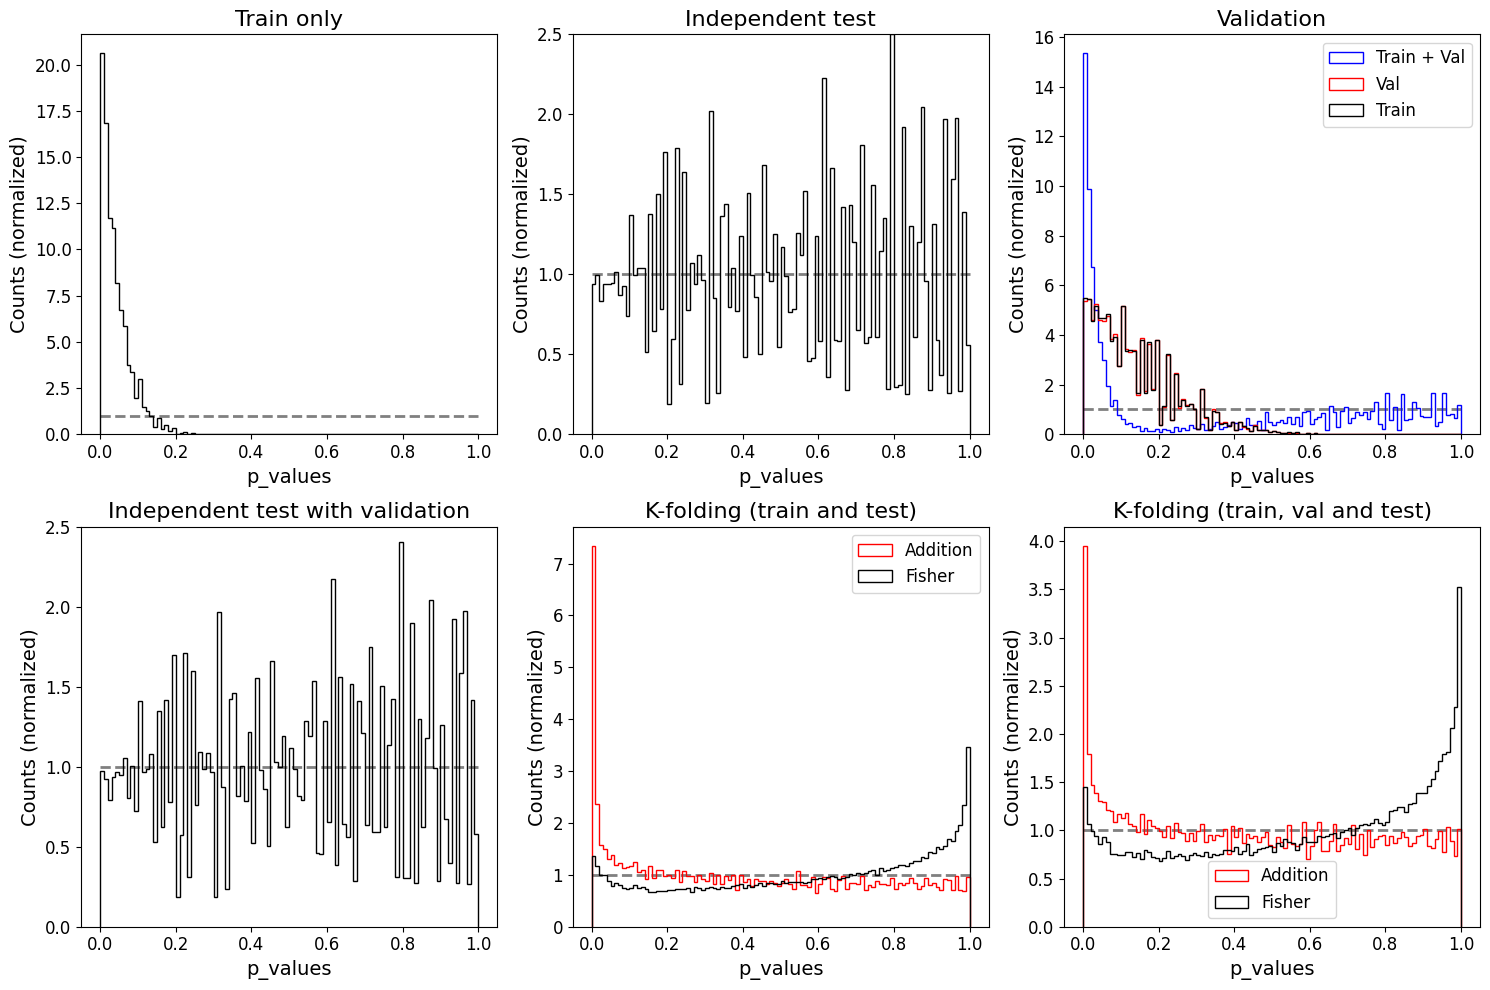

In [107]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=np.linspace(0,1,101)

p_train_pick_on_train = np.load(directory+"validation/p_train_pick_on_train.npy")
p_train_pick_on_train_val = np.load(directory+"validation/p_train_pick_on_train_val.npy")
p_test_pick_on_train = np.load(directory+"validation/p_test_pick_on_train.npy")
p_test_pick_on_train_val = np.load(directory+"validation/p_test_pick_on_train_val.npy")
p_val_pick_on_train_val = np.load(directory+"validation/p_val_pick_on_train_val.npy")
p_train_val_pick_on_train_val = np.load(directory+"validation/p_train_val_pick_on_train_val.npy")

p_fisher = np.load(directory+"k_fold/fishers_method.npy")
p_add = np.load(directory+"k_fold/addition.npy")
p_fisher_with_val = np.load(directory+"k_fold/fishers_method_with_validation.npy")
p_add_with_val = np.load(directory+"k_fold/addition_with_validation.npy")


for i in range(len(ax)):
    ax[i].set_xlabel("p_values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")

ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
ax[0].set_title("Train only")

ax[1].hist(p_test_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
ax[1].set_title("Independent test")
ax[1].set_ylim(0,2.5)

ax[2].hist((p_train_pick_on_train_val, p_val_pick_on_train_val, p_train_val_pick_on_train_val), bins=bins_plot, histtype="step", color=("black", "red", "blue"), label=("Train", "Val", "Train + Val"), density=True)
ax[2].set_title("Validation")
ax[2].legend()
#ax[2].set_ylim(0,2.5)

ax[3].hist(p_test_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[3].set_title("Independent test with validation")
ax[3].set_ylim(0,2.5)

ax[4].hist((p_fisher, p_add), bins=bins_plot, histtype="step", color=("black", "red"), label=("Fisher", "Addition"), density=True)
ax[4].set_title("K-folding (train and test)")
ax[4].legend()

ax[5].hist((p_fisher_with_val, p_add_with_val), bins=bins_plot, histtype="step", color=("black", "red"), label=("Fisher", "Addition"), density=True)
ax[5].set_title("K-folding (train, val and test)")
ax[5].legend()

"""ax[4].hist(p_add, bins=bins_plot, histtype="step", color="black", density=True)
ax[4].set_title("K-folding (train and test)")

ax[5].hist(p_add_with_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[5].set_title("K-folding (train, val and test)")
"""
#ax[4].set_ylim(0,2.5)

fig.tight_layout()

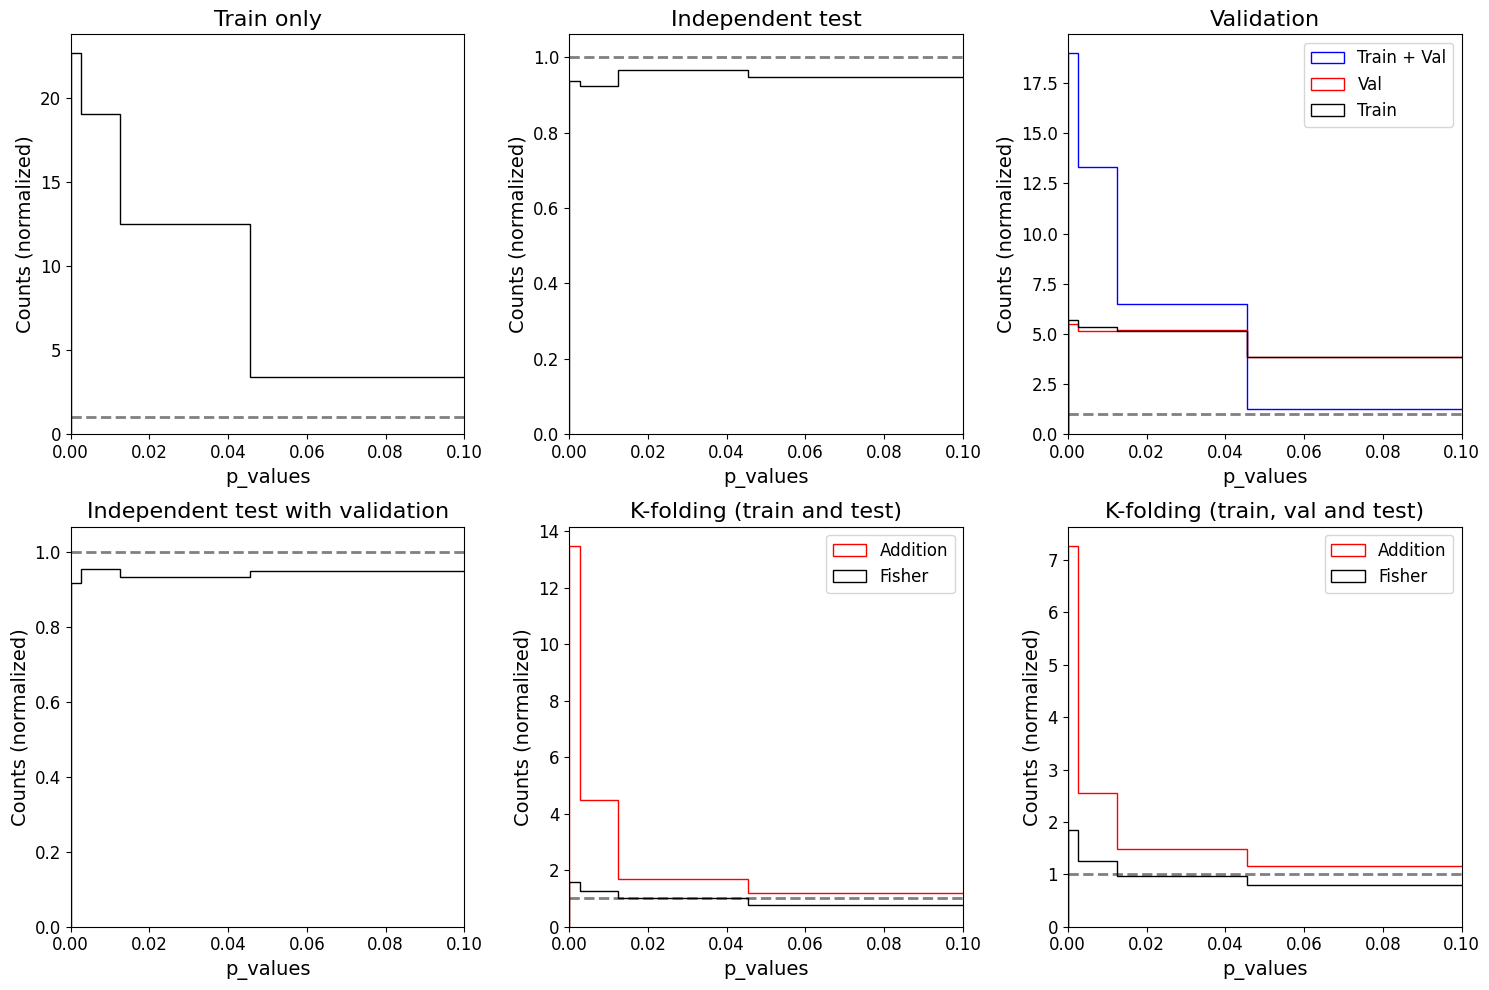

In [108]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]

p_train_pick_on_train = np.load(directory+"validation/p_train_pick_on_train.npy")
p_train_pick_on_train_val = np.load(directory+"validation/p_train_pick_on_train_val.npy")
p_test_pick_on_train = np.load(directory+"validation/p_test_pick_on_train.npy")
p_test_pick_on_train_val = np.load(directory+"validation/p_test_pick_on_train_val.npy")
p_val_pick_on_train_val = np.load(directory+"validation/p_val_pick_on_train_val.npy")
p_train_val_pick_on_train_val = np.load(directory+"validation/p_train_val_pick_on_train_val.npy")

p_fisher = np.load(directory+"k_fold/fishers_method.npy")
p_add = np.load(directory+"k_fold/addition.npy")
p_fisher_with_val = np.load(directory+"k_fold/fishers_method_with_validation.npy")
p_add_with_val = np.load(directory+"k_fold/addition_with_validation.npy")


for i in range(len(ax)):
    ax[i].set_xlabel("p_values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")

ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
ax[0].set_title("Train only")

ax[1].hist(p_test_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
ax[1].set_title("Independent test")
#ax[1].set_ylim(0,2.5)

ax[2].hist((p_train_pick_on_train_val, p_val_pick_on_train_val, p_train_val_pick_on_train_val), bins=bins_plot, histtype="step", color=("black", "red", "blue"), label=("Train", "Val", "Train + Val"), density=True)
ax[2].set_title("Validation")
ax[2].legend()
#ax[2].set_ylim(0,2.5)

ax[3].hist(p_test_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[3].set_title("Independent test with validation")
#ax[3].set_ylim(0,2.5)

ax[4].hist((p_fisher, p_add), bins=bins_plot, histtype="step", color=("black", "red"), label=("Fisher", "Addition"), density=True)
ax[4].set_title("K-folding (train and test)")
ax[4].legend()

ax[5].hist((p_fisher_with_val, p_add_with_val), bins=bins_plot, histtype="step", color=("black", "red"), label=("Fisher", "Addition"), density=True)
ax[5].set_title("K-folding (train, val and test)")
ax[5].legend()
"""
ax[4].hist(p_add, bins=bins_plot, histtype="step", color="black", density=True)
ax[4].set_title("K-folding (train and test)")

ax[5].hist(p_add_with_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[5].set_title("K-folding (train, val and test)")"""


for i in range(len(ax)):
    ax[i].set_xlim(0,0.1)
fig.tight_layout()